# House Prices Advanced Regression and Analysis


## This is not only a house price regression problem, but apply to all similar problems sharing the following criterias:
### 1. Only one outcome (observation) feature, could be either categorical or numeric.
### 2. The parameters/features which could affect the outcome is too many to fit any human predictable model or function.
### 3. The parameters/features to affect the outcome should be less than the training samples.
### 4. There are a mix of categorical and numeric features.

In [3]:
#-----------------------------------------------------------------------------#
# Load Packages for 
    #data wrangling, modeling, statistical analysis and visualization
#-----------------------------------------------------------------------------#
import pandas as pd
import numpy as np
import math
import seaborn as sns
from IPython import display
from ipywidgets import interact, widgets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



In [30]:
#-----------------------------------------------------------------------------#
#Data wrangling: Load training data and transform to analyzable format
#-----------------------------------------------------------------------------#
# load data to pandas dataframe
df = pd.read_csv('train.csv', index_col=['Id']) 

# fill NA for both catogorial and numerical data
for col in df.columns:
    if df[col].dtypes == 'object':
        df[col]=df[col].fillna('0') #fill na with 0
    else:
        df[col]=df[col].fillna(0)

# for GrageYrBlt data, fill NA with 0 is not right, fill with maximum value
maxage = df.GarageYrBlt.max()
df.GarageYrBlt = df['GarageYrBlt'].replace(0, maxage)
        
# transform year data to age for cumputation
for col in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    df[col] = df['YrSold'] - df[col]

# change SalePrice to fold of 1k
df['SalePrice'] = df.SalePrice / 1000

# dispaly data shape
df.shape   

(1460, 80)

In [75]:
# Data Exploration: selling price change during years with Zoning info

def plotyear(year):
    data = df[df.YrSold == year].sort_values(['MSZoning'],ascending=False)
    
    ax = sns.lmplot('GrLivArea','SalePrice',data, hue='MSZoning',height=5,aspect=3)
    
    plt.xlabel('GrLivArea')
    plt.ylabel('SalePrice')
    plt.title(year,fontsize=20)
    ax.set(ylim=(0,700))
    ax.set(xlim=(0,4000))
    
interact(plotyear,year=widgets.IntSlider(min=2006,max=2010,step=1))
print('RM: Residential Medium Density,',
     'RL: Residential Low Density,',
     'RH: Residential High Density,',
     'FV: Floating Village Residential,',
     'C: Commercial.')

interactive(children=(IntSlider(value=2006, description='year', max=2010, min=2006), Output()), _dom_classes=(…

RM: Residential Medium Density, RL: Residential Low Density, RH: Residential High Density, FV: Floating Village Residential, C: Commercial.


In [72]:
# Question1: Is there a pattern for neighborhood in terms of house quality and price?
import matplotlib.cm as cm
import matplotlib.colors as colors

def plotyear_2(year):
    #select data according to year
    data = df[df.YrSold == year].sort_values(['LotArea','SalePrice'],ascending=False)
    #size info from LotArea
    area = data.LotArea * 0.01
    #color infor from neighboorhood
    neighborhood = df.Neighborhood.unique()
    
    explain_neighborhood = {
      'Blmngtn':'Bloomington Heights',
      'Blueste':'Bluestem',
      'BrDale':'Briardale',
      'BrkSide':'Brookside',
       'ClearCr':'Clear Creek',
       'CollgCr':'College Creek',
       'Crawfor':'Crawford',
       'Edwards':'Edwards',
       'Gilbert':'Gilbert',
       'IDOTRR':'Iowa DOT and Rail Road',
       'MeadowV':'Meadow Village',
       'Mitchel':'Mitchell',
       'NAmes':'North Ames',
       'NoRidge':'Northridge',
       'NPkVill':'Northpark Villa',
       'NridgHt':'Northridge Heights',
       'NWAmes':'Northwest Ames',
       'OldTown':'Old Town',
       'SWISU':'South & West of Iowa State University',
       'Sawyer':'Sawyer',
       'SawyerW':'Sawyer West',
       'Somerst':'Somerset',
       'StoneBr':'Stone Brook',
       'Timber':'Timberland',
       'Veenker':'Veenker'
    }
    colormap = cm.gist_rainbow
    colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 1, len(neighborhood))]
    color_label = dict(zip(neighborhood,colorlist))
    color = data.Neighborhood.map(color_label)
    
    #Plot OverallQual and SalePrice relationship
    ax = data.plot.scatter('SalePrice','OverallQual',
                     s=area,c=color,
                     linewidths=1,edgecolors='k',
                     figsize=(15,6))
    ax.set(ylim=(0,12))
    ax.set(xlim=(0,700))
    plt.xlabel('SalePrice (k)',fontsize=18)
    plt.ylabel('OverallQual',fontsize=18)
    plt.title(year,fontsize=20)
    
    #plot legend
    for i in range(len(colorlist)):
        plt.scatter(-100,0,label=explain_neighborhood[neighborhood[i]],
                    color=color_label[neighborhood[i]],s=50,linewidths=1,edgecolors='k')
    plt.legend(ncol=1,bbox_to_anchor=(1, 1),loc=2)
    
    plt.savefig('plotyear_2_'+str(year)+'.png')


In [73]:
interact(plotyear_2,year=widgets.IntSlider(min=2006,max=2010,step=1))

interactive(children=(IntSlider(value=2006, description='year', max=2010, min=2006), Output()), _dom_classes=(…

<function __main__.plotyear_2(year)>

# ----------------------------------------------------------------------------- #
## Q: How bedroom number contributes to Sale Price?
# ----------------------------------------------------------------------------- #

In [142]:

# Step-1: Plot the ralationship of SalePrice with Living Area with BedRoom information

def plot_bedroom(df):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    colors = dict(zip(df.BedroomAbvGr.unique(),np.array(['C'+str(s) for s in range(len(df.BedroomAbvGr.unique()))])))
    plt.scatter(df.GrLivArea, df.SalePrice,
                s=df.BedroomAbvGr*20,
                c=df.BedroomAbvGr.replace(colors),alpha=0.5)

    for i in range(len(df.BedroomAbvGr.unique())):
        plt.scatter(0,0,
                    c = colors[df.BedroomAbvGr.unique()[i]], alpha=0.5,
                    label=df.BedroomAbvGr.unique()[i])
    ax.set_xlim(left=100)
    ax.set_ylim(df.SalePrice.min()-3,df.SalePrice.max()+3)
    plt.legend(title='Bedroom No.')
    plt.xlabel('GrLivArea')
    plt.ylabel('SalePrice (k)')
    plt.show()

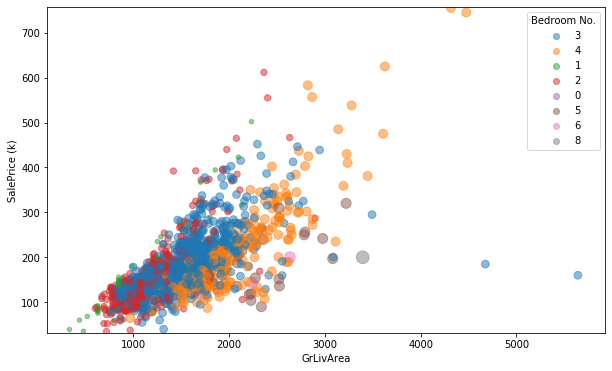

In [143]:
# Step-1: Plot the ralationship of SalePrice with Living Area with BedRoom information
plot_bedroom(df)

In [22]:
def plot_mean_sd_BR(df):
    mean = df.groupby('BedroomAbvGr').SalePrice.mean()
    sd = df.groupby('BedroomAbvGr').SalePrice.std()
    mean.plot(kind='bar', fill=False, linewidth = 1, color='k', yerr=sd)
    plt.ylabel('Sale Price (k)')


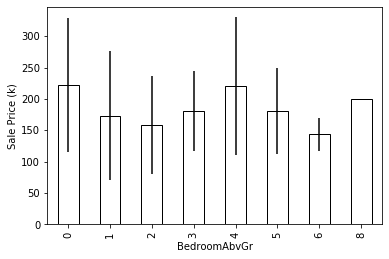

In [21]:
plot_mean_sd_BR(df)

(675, 80)

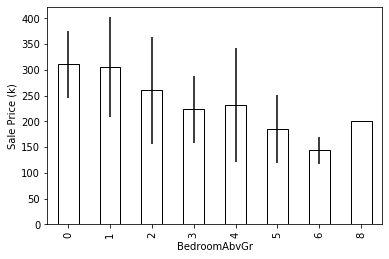

In [23]:
df1500 = df[df.GrLivArea > 1500]
plot_mean_sd_BR(df1500)
df1500.shape

In [24]:
# ANOVA analysis with post tukey hsd pairwise comparasion
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

br_stats = ols('SalePrice ~ BedroomAbvGr', data=df1500).fit()
anova = sm.stats.anova_lm(br_stats, typ=2)
print(anova)

                    sum_sq     df          F    PR(>F)
BedroomAbvGr  1.416258e+05    1.0  19.308933  0.000013
Residual      4.936273e+06  673.0        NaN       NaN


In [26]:

print(pairwise_tukeyhsd(df1500.SalePrice, df1500.BedroomAbvGr, alpha=0.025))

  Multiple Comparison of Means - Tukey HSD, FWER=0.03   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     0      1   -5.4633    0.9 -183.3537  172.427  False
     0      2   -50.298    0.9 -214.0949 113.4989  False
     0      3  -86.8252 0.6258 -247.8204    74.17  False
     0      4  -79.3405 0.7199 -240.9431   82.262  False
     0      5 -124.5233 0.2594 -296.4776  47.4309  False
     0      6 -166.5543 0.0873 -358.2071  25.0984  False
     0      8 -110.3333    0.9 -431.0297  210.363  False
     1      2  -44.8347 0.6362 -128.8069  39.1375  False
     1      3  -81.3619 0.0167 -159.7286  -2.9951   True
     1      4  -73.8772 0.0511 -153.4842   5.7298  False
     1      5   -119.06 0.0023 -218.0053 -20.1147   True
     1      6  -161.091 0.0015 -291.2934 -30.8886   True
     1      8   -104.87    0.9 -393.0853 183.3453  False
     2      3  -36.5272 0.0242  -72.9388  -0.1156   True
     2      4  -29.0425  0.227 

In [27]:
# choose the best model according to random2_search_mse in First model
import xgboost as xgb
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15000000000000002,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=150, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6500000000000001, verbosity=1)

In [124]:
# Training model
y = df.SalePrice
X = df.drop('SalePrice',axis=1)

le = LabelEncoder()
X = X.apply(lambda x: le.fit_transform(x))
categorical_mask = (X.dtypes == 'object')
ohe = OneHotEncoder(categorical_features=categorical_mask, sparse=False)
X = ohe.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15000000000000002,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=150, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6500000000000001, verbosity=1)

In [125]:
# Validate model accuaracy 
y_predict = model.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

0.9015321055854749

In [133]:
# simulation with other features the same value but only assign bedroom numbers randomly.

def simulate_bedroom(df_s):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,8) for i in range(n)] # randomize bedroom numbers
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    # add one more criteria to make random bedroom number more realistic
    for i in range(n):
        if df_s.iloc[i]['BedroomAbvGr'] > df_s.iloc[i]['GrLivArea']/300:
            df_s.iloc[i]['BedroomAbvGr']=int(df_s.iloc[i]['GrLivArea']/300)
    
    return df_s

In [148]:
def simulation_price(model,df_new):
    X = df_new
    X = X.apply(lambda x: le.fit_transform(x))
    X = ohe.fit_transform(X)

    df_new['SalePrice'] = model.predict(X)
    
    return df_new.sort_values(by=['BedroomAbvGr'])

99 1552


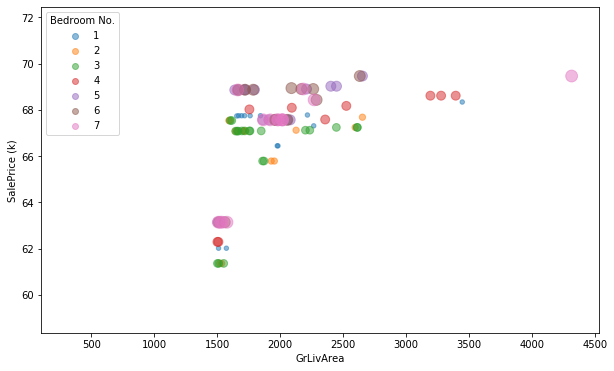

25 2000


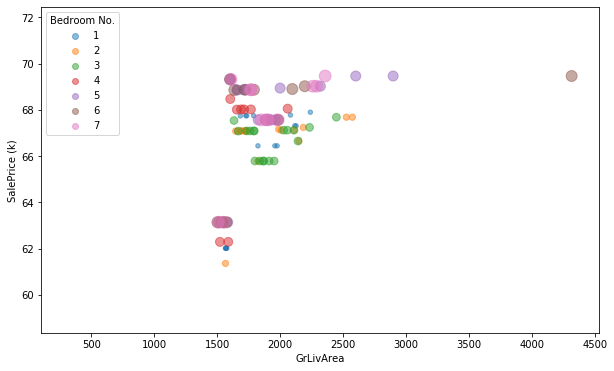

5 2259


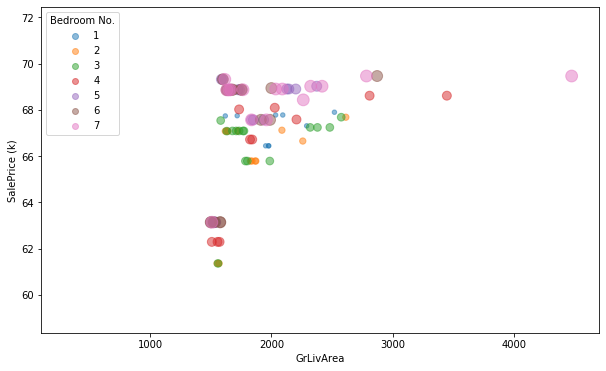

46 1728


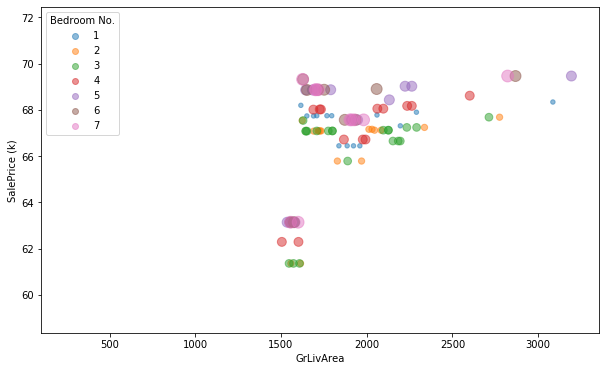

In [149]:
# Simulation
df1 = df1500.drop('SalePrice',axis=1)

for i in range(4):
    
    df_s = df1.sample(n=100,replace=True)
    df_new = simulate_bedroom(df_s)
    df_new = simulation_price(model,df_new)
    plot_bedroom(df_new)

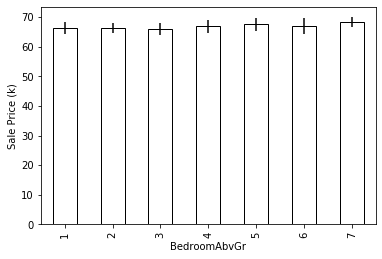

In [147]:
plot_mean_sd_BR(df_new)

In [150]:
br_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new).fit()
anova = sm.stats.anova_lm(br_stats, typ=2)
print(anova)

                  sum_sq    df         F   PR(>F)
BedroomAbvGr    4.566690   1.0  1.023974  0.31407
Residual      437.057495  98.0       NaN      NaN


In [152]:
print(pairwise_tukeyhsd(df_new.SalePrice, df_new.BedroomAbvGr, alpha=0.025))

Multiple Comparison of Means - Tukey HSD, FWER=0.03
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -1.1321 0.7374 -3.6524 1.3881  False
     1      3  -1.2157 0.6198 -3.5919 1.1604  False
     1      4  -0.5178    0.9 -3.1703 2.1347  False
     1      5   -0.613    0.9 -3.1722 1.9462  False
     1      6    0.141    0.9 -2.7103 2.9924  False
     1      7   0.0205    0.9 -2.7542 2.7952  False
     2      3  -0.0836    0.9 -2.3689 2.2017  False
     2      4   0.6143    0.9 -1.9572 3.1857  False
     2      5   0.5191    0.9 -1.9559 2.9942  False
     2      6   1.2732 0.7197  -1.503 4.0493  False
     2      7   1.1526 0.7786 -1.5447 3.8499  False
     3      4   0.6979    0.9 -1.7324 3.1282  False
     3      5   0.6027    0.9 -1.7254 2.9309  False
     3      6   1.3568 0.6177 -1.2892 4.0027  False
     3      7   1.2362 0.6751  -1.327 3.7994  False
     4      5  -0.0952    0.9 -2.7047 2.5144  False
     4      

In [193]:
# simulation with features in list cols the same with original dataset but assign bedroom numbers randomly.

def simulate_bedroom_cols(df_s,cols):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,8) for i in range(n)] # randomize bedroom numbers
        elif col in cols:
            pass
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    # add one more criteria to make random bedroom number more realistic
    for i in range(n):
        if df_s.iloc[i]['BedroomAbvGr'] > df_s.iloc[i]['GrLivArea']/300:
            df_s.iloc[i]['BedroomAbvGr']=int(df_s.iloc[i]['GrLivArea']/300)
    
    return df_s

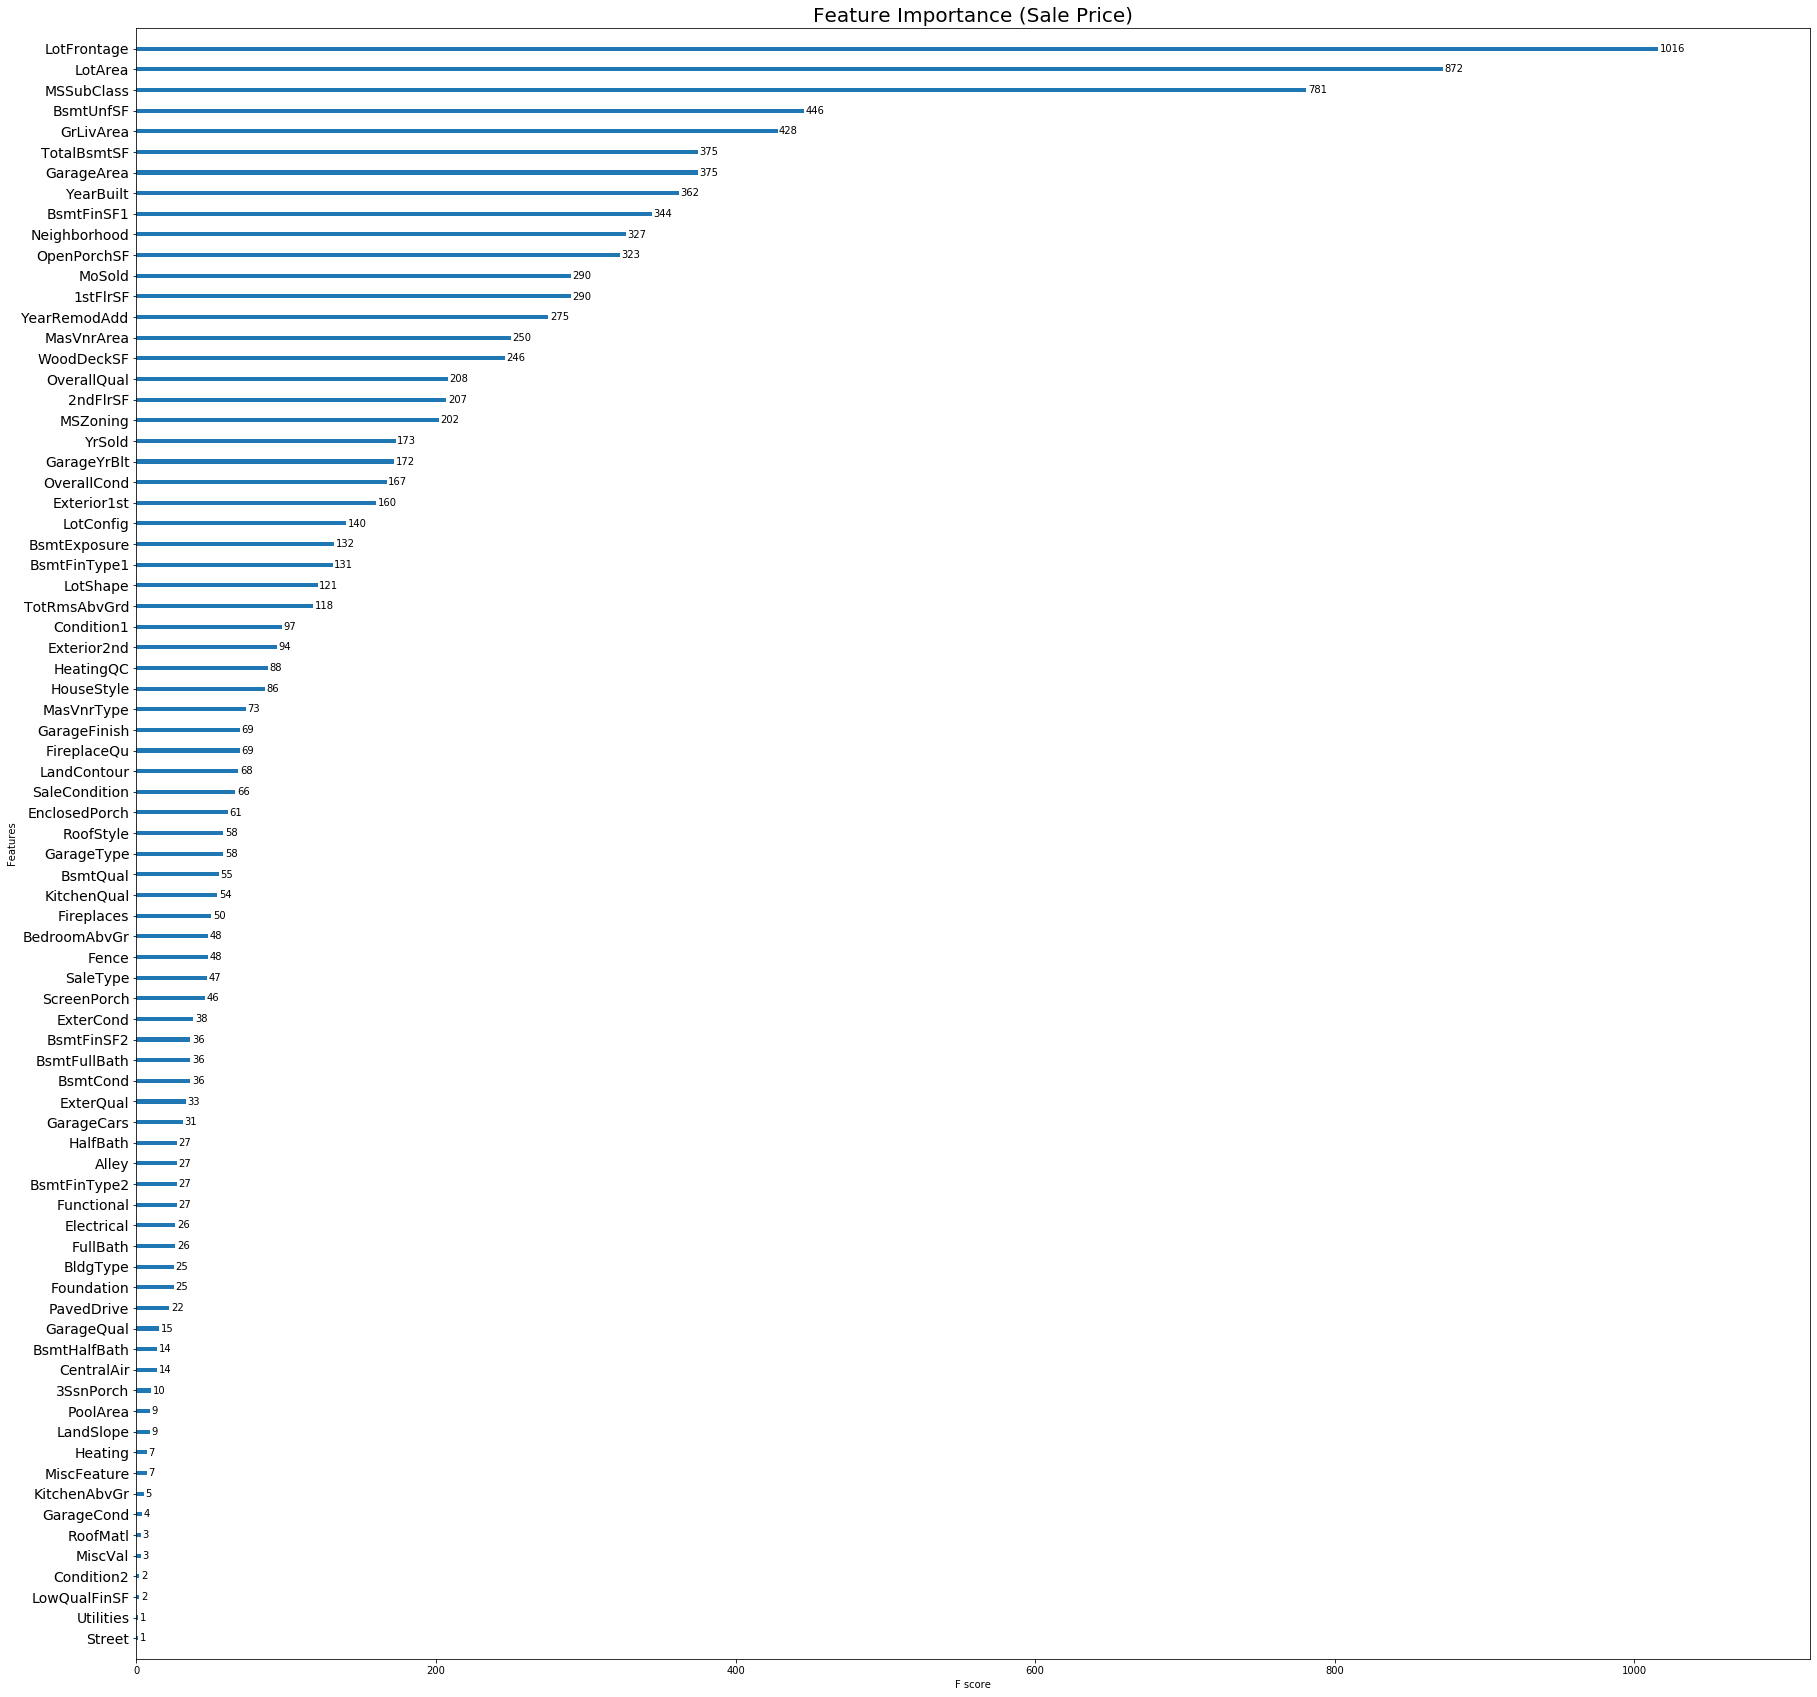

In [153]:
fig1, ax1 = plt.subplots(1,1,figsize=(30,30))
from xgboost import plot_importance
g = plot_importance(model,ax=ax1,grid=False)

oldy = g.yaxis.get_majorticklabels()

features = ['f'+str(x) for x in range(len(df1.columns))]
feature_dict = dict(zip(features,df1.columns))

newy = [str(feature_dict[y._text]) for y in oldy]
g.set_yticklabels(newy, rotation=0, fontsize = 14)

plt.title('Feature Importance (Sale Price)',fontsize=20)

plt.show()

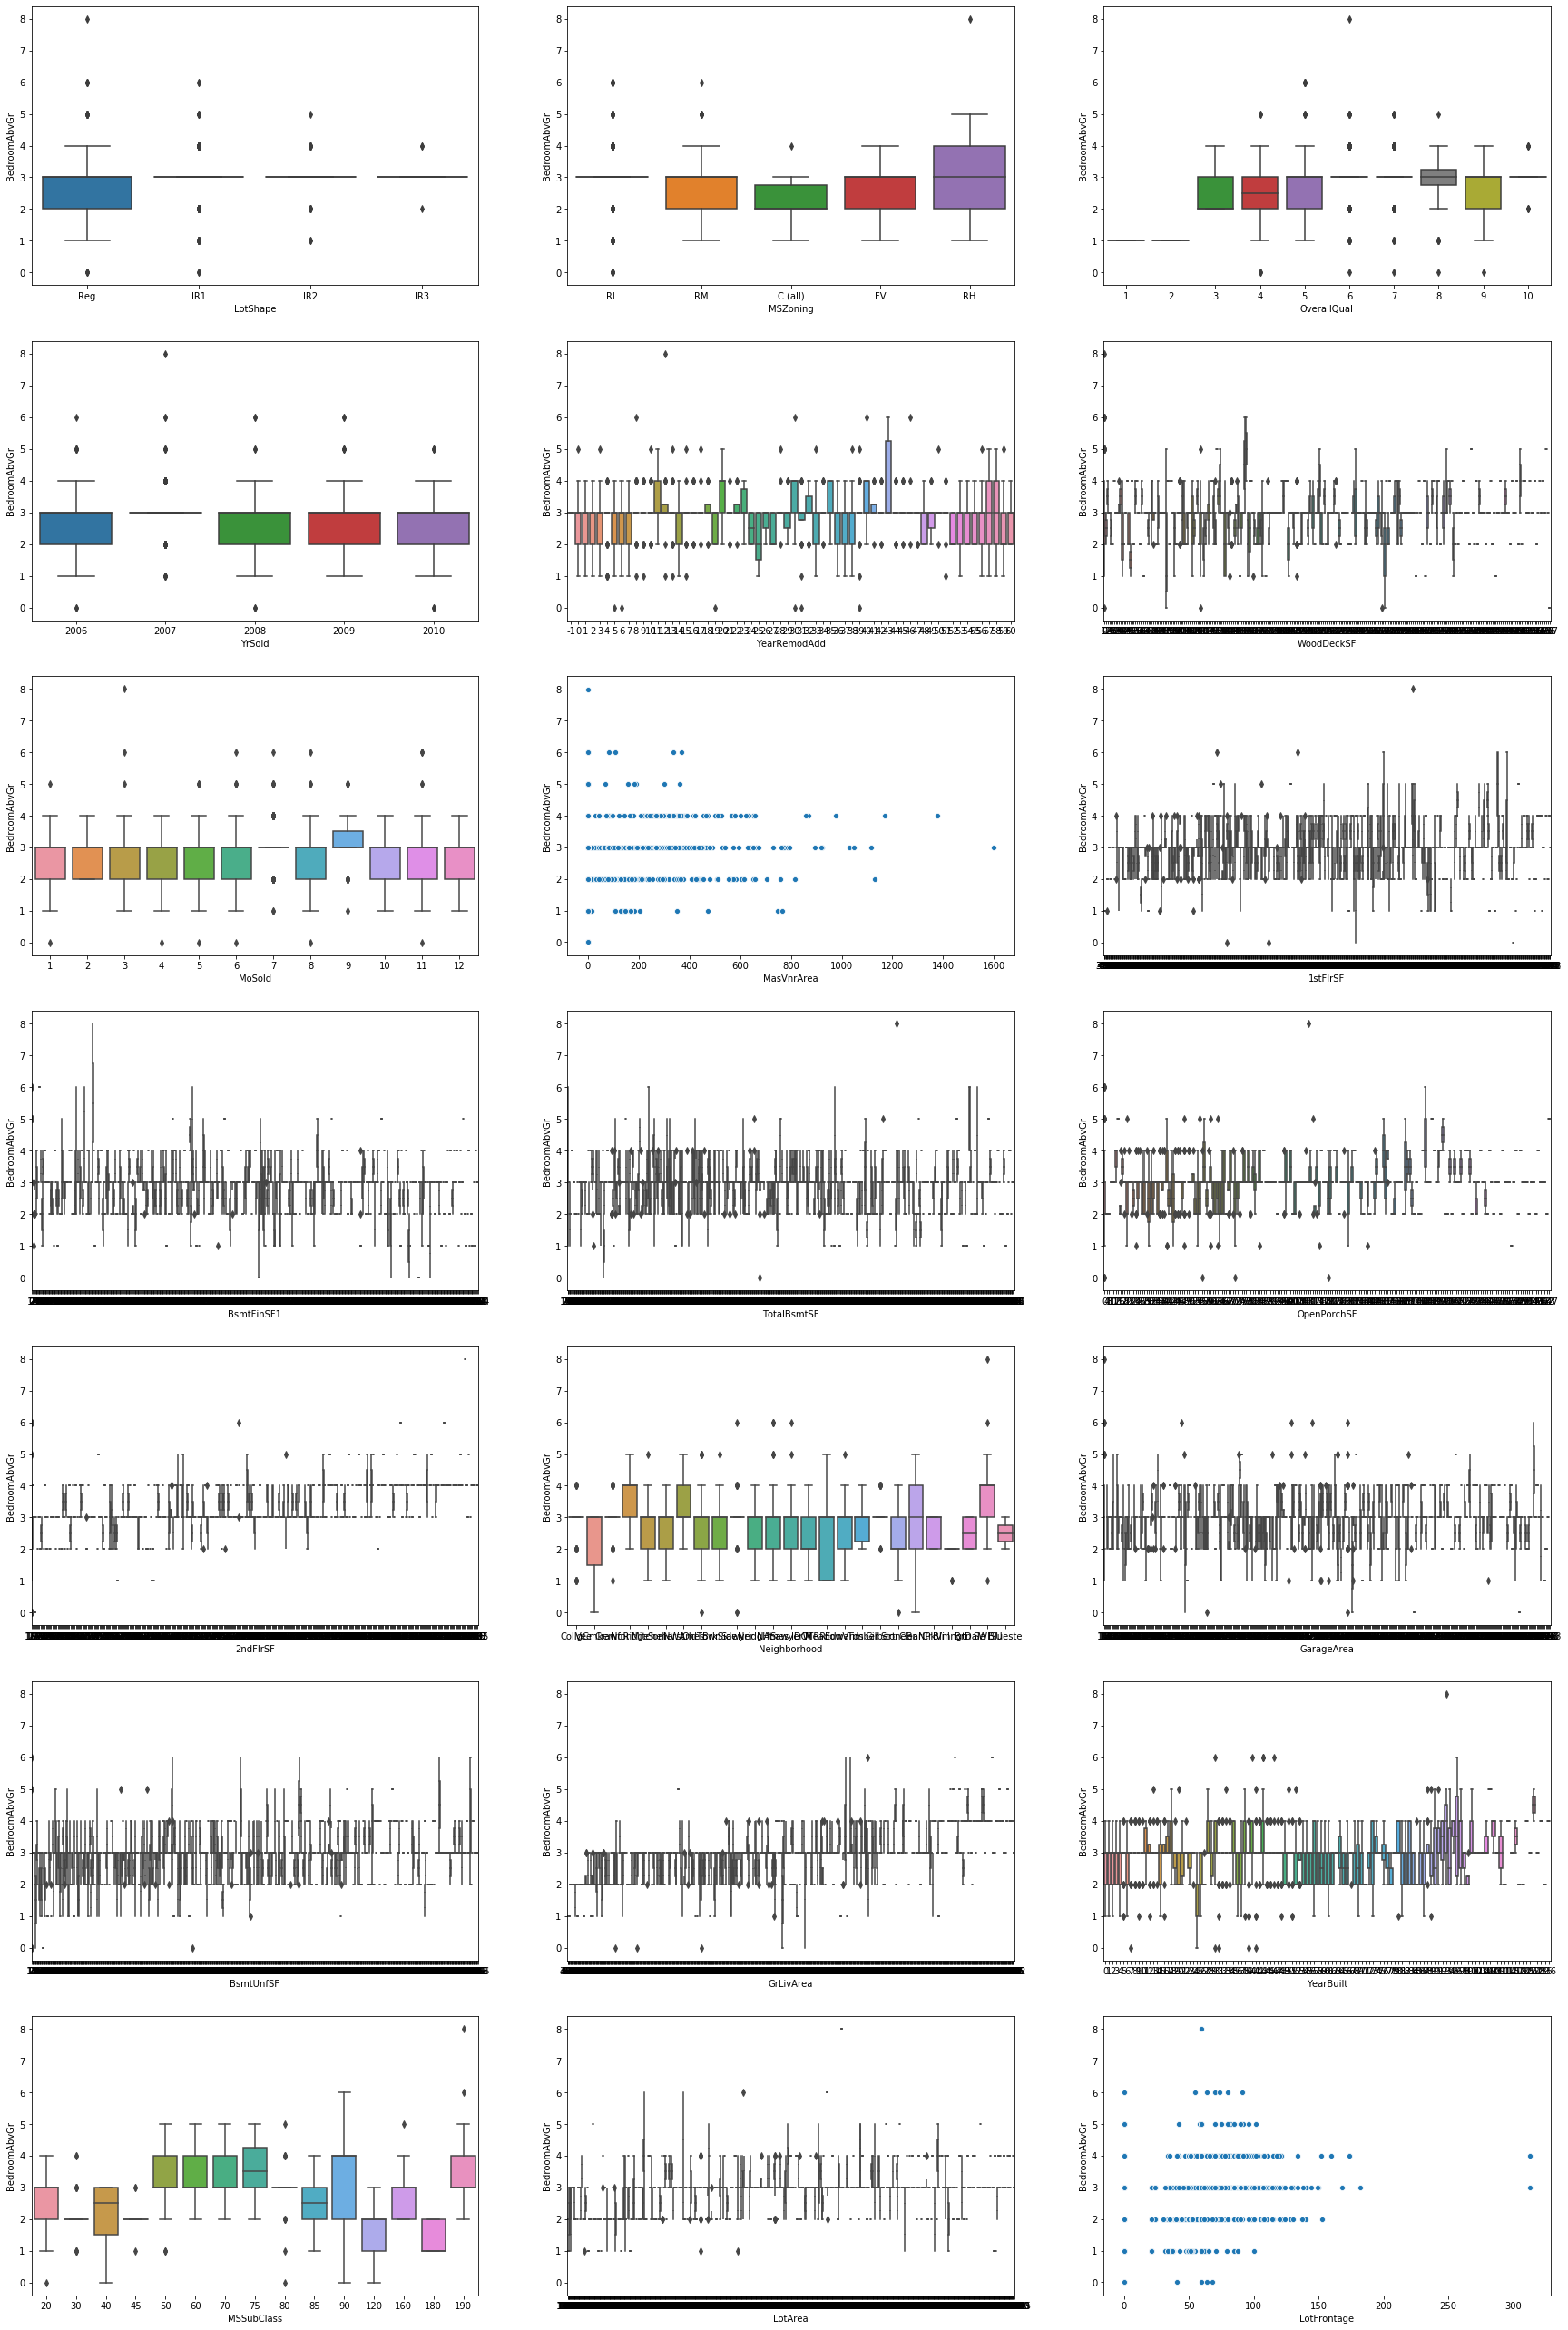

In [434]:
import seaborn as sns
fig = plt.figure(figsize=(30,60))
y_col = 'BedroomAbvGr'
a = 0 #active plot number
for col in newy[55:]:
    a += 1
    ax = fig.add_subplot(9,3,a)
    if df[col].dtype == 'float64':
        sns.scatterplot(x=col, y=y_col, data=df,ax=ax)
    else:
        sns.catplot(x=col, y=y_col,kind='box',data=df,ax=ax)

    ax.set_xlabel(col)
    plt.close(2)

In [203]:
# get cols that are more important than bedroom
cols = newy[34:]

In [208]:
def plot_mean_sd_BR_2(df,name):
    
    mean = df.groupby('BedroomAbvGr').SalePrice.mean()
    sd = df.groupby('BedroomAbvGr').SalePrice.std()
    mean.plot(kind='bar', fill=False, linewidth = 1, color='k', yerr=sd)
    plt.ylabel('Sale Price (k)')
    plt.title(name)

0
64 1720
1
0 1559
2
37 1657
3
48 2110
4
6 1635
5
33 2076
6
37 1700
7
83 1632
8
90 2256
9
84 1640
10
8 1768
11
65 1709
12
39 1680
13
17 2236
14
17 1616
15
4 1839
16
27 1776
17
58 1718
18
99 1947
19
47 1576
20
27 1856
21
46 1675
22
39 1734
23
89 1788
24
21 1764
25
97 2291
26
55 1738
27
78 1511
28
80 4476
29
84 1694
30
98 2117
31
79 2263
32
76 1872
33
24 1768
34
85 1505
35
5 1928
36
83 2184
37
38 2090
38
75 1575
39
55 1525
40
80 1935
41
58 2021
42
6 2515
43
1 1624


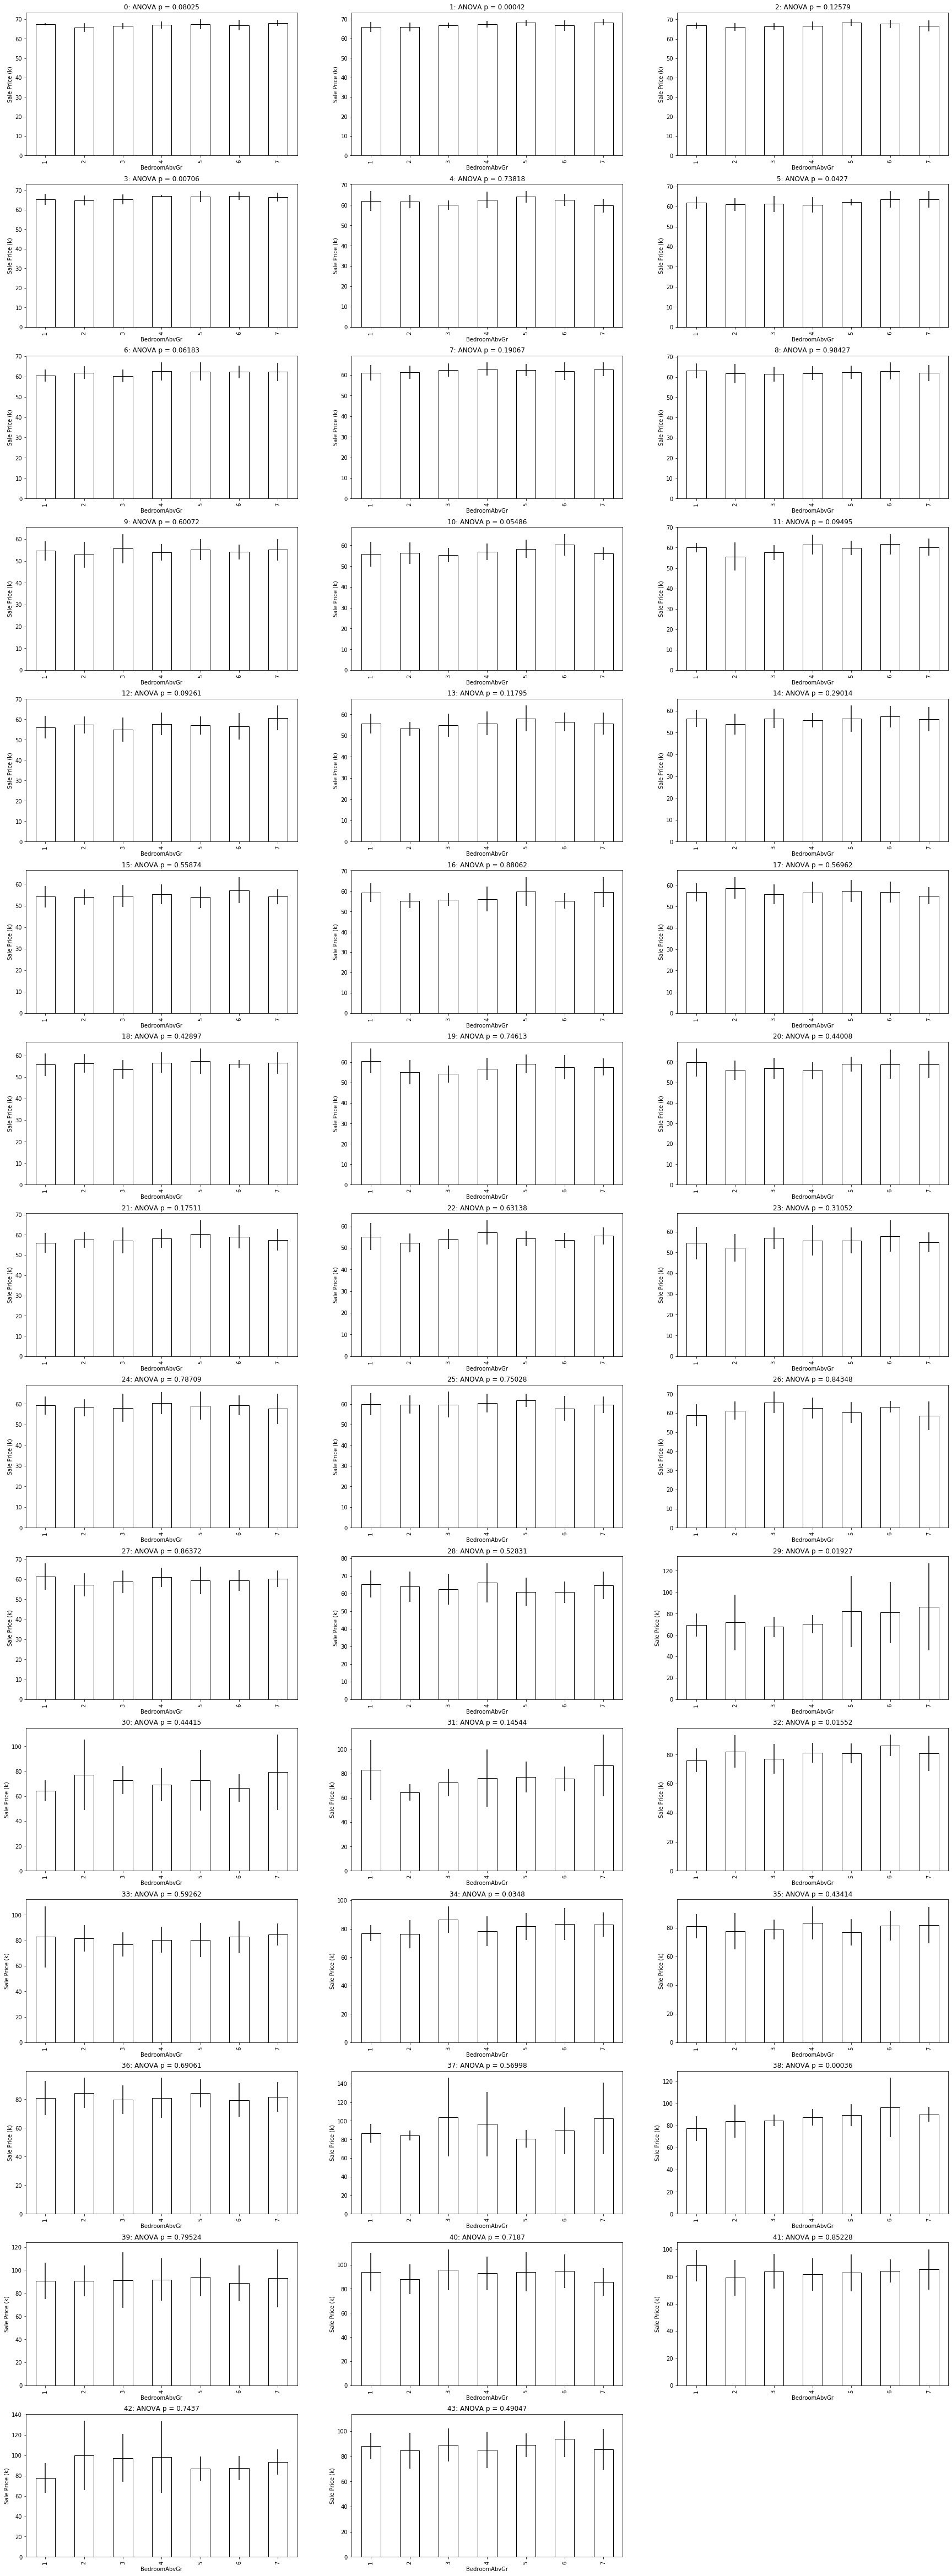

In [226]:
# Simulation
df1 = df1500.drop('SalePrice',axis=1)
fig3 = plt.figure(figsize=(30,85))

for i in range(len(cols)):
    print(i)
    df_s = df1.sample(100,replace=True)
    df_new = simulate_bedroom_cols(df_s,cols[:i]) #adding features from less important to more
    df_new2 = simulation_price(model,df_new)
    
    #Add ANOVA analysis
    new_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new).fit()
    aov = sm.stats.anova_lm(new_stats, typ=2)
    name = str(i)+': ANOVA p = '+str(round(aov['PR(>F)']['BedroomAbvGr'],5) )
    
    #plot mean
    ax = fig3.add_subplot(15,3,i+1)
    plot_mean_sd_BR_2(df_new2,name)


0
51 2704
1
72 1978
2
9 1920
3
84 2138
4
53 1908
5
19 1839
6
77 1861
7
46 1601
8
66 1552
9
79 1690
10
45 2161
11
97 2601
12
36 2078
13
65 2169
14
8 2448
15
9 1680
16
41 2243
17
8 1771
18
2 1635
19
51 2482
20
35 1734
21
86 2127
22
57 2126
23
38 1582
24
99 1656
25
3 1502
26
26 2223
27
0 1616
28
12 2259
29
94 2229
30
69 2117
31
15 1614
32
34 1664
33
84 1812
34
65 1509
35
31 1970
36
49 2274
37
79 3086
38
45 1629
39
61 2624
40
56 1923
41
9 1803
42
20 1571
43
48 1684


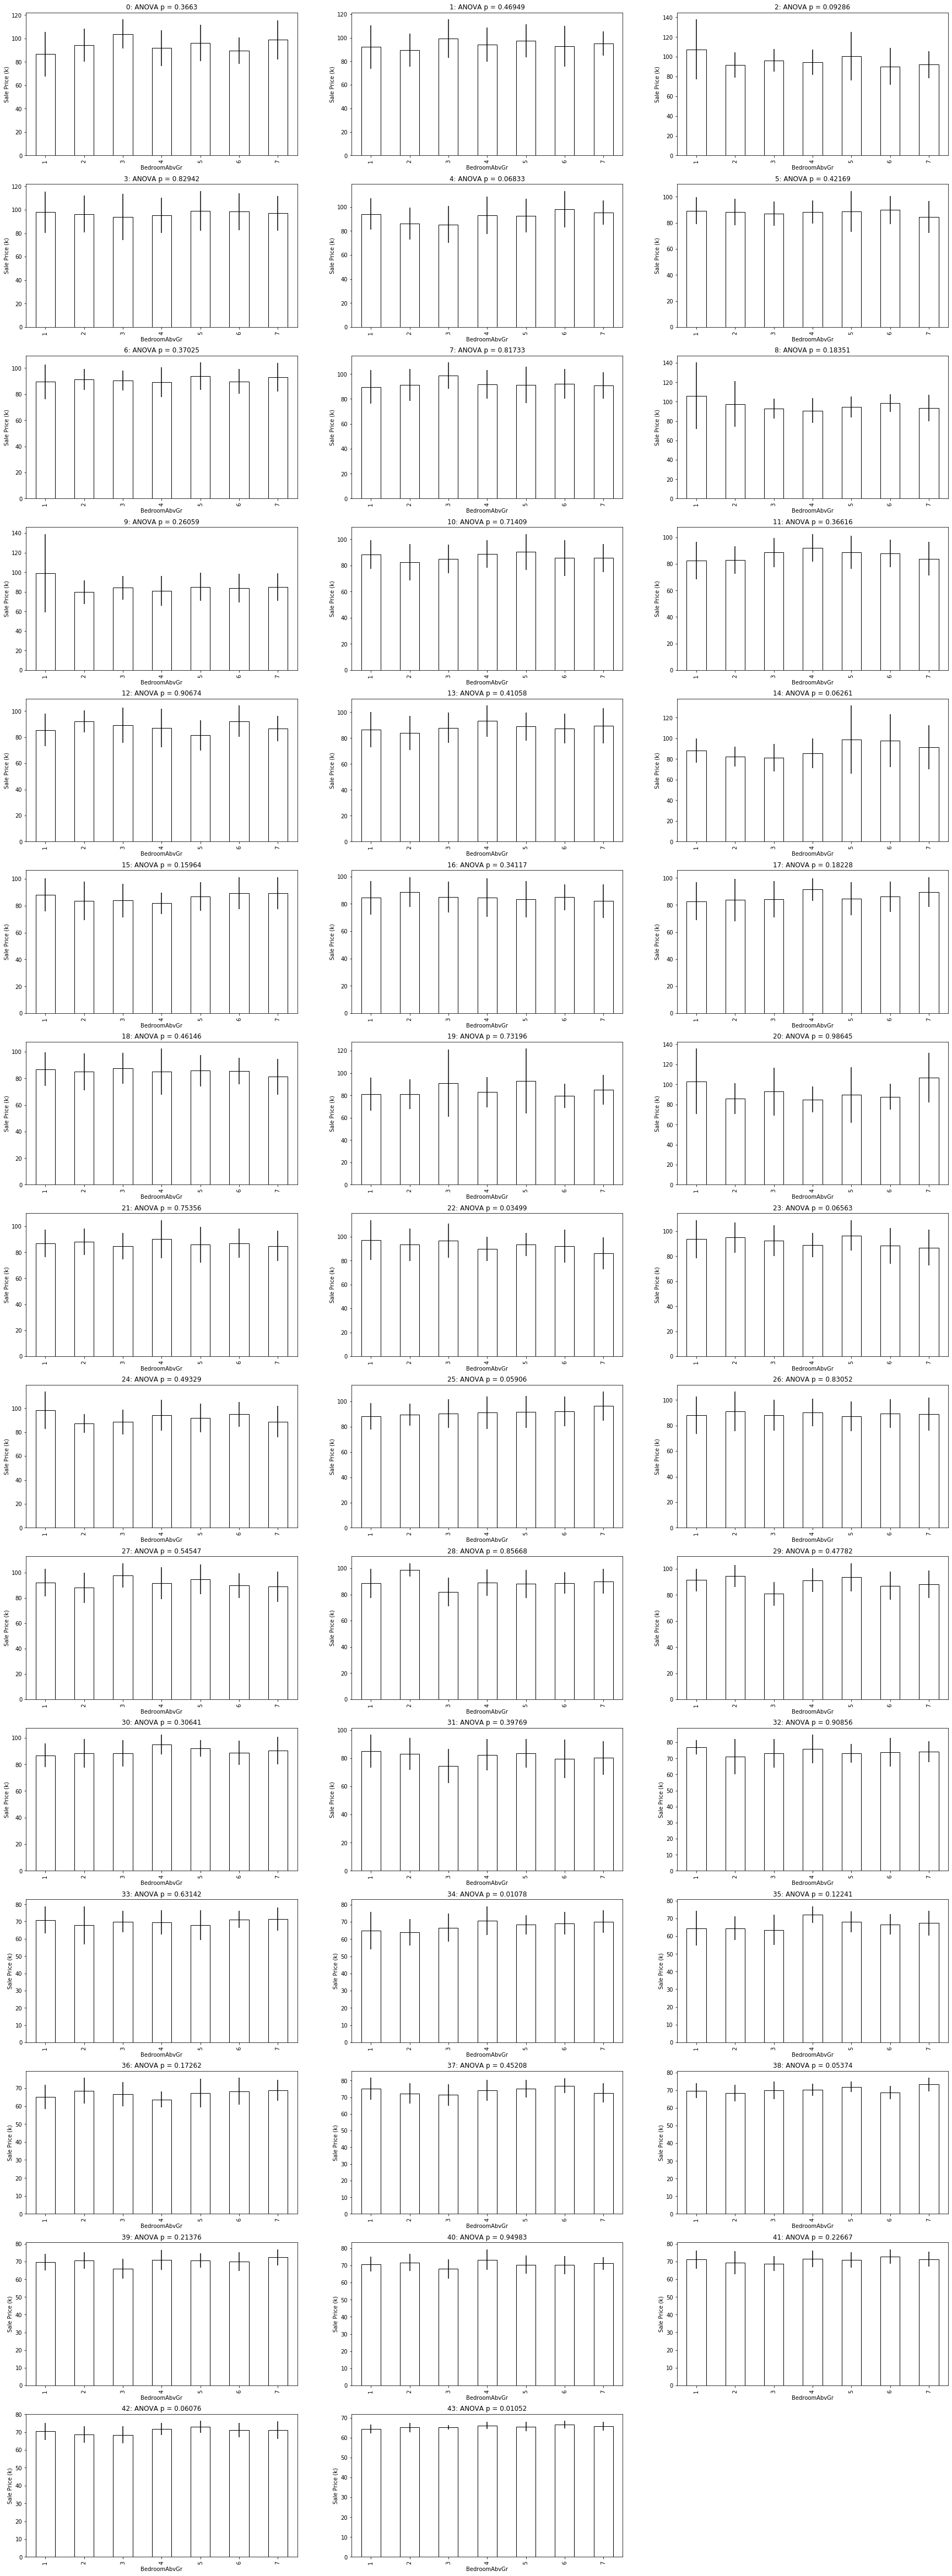

In [228]:
fig4 = plt.figure(figsize=(30,85))
for i in range(len(cols)):
    print(i)
    df_s = df1.sample(100,replace=True)
    df_new = simulate_bedroom_cols(df_s,cols[i:])# dilimit features from less important to more
    df_new2 = simulation_price(model,df_new)
    
    #Add ANOVA analysis
    new_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new).fit()
    aov = sm.stats.anova_lm(new_stats, typ=2)
    name = str(i)+': ANOVA p = '+str(round(aov['PR(>F)']['BedroomAbvGr'],5) )
    
    #plot mean
    ax = fig4.add_subplot(15,3,i+1)
    plot_mean_sd_BR_2(df_new2,name)


1
18 1993
2
43 2448
3
205 1575
4
216 1617
5
51 1894


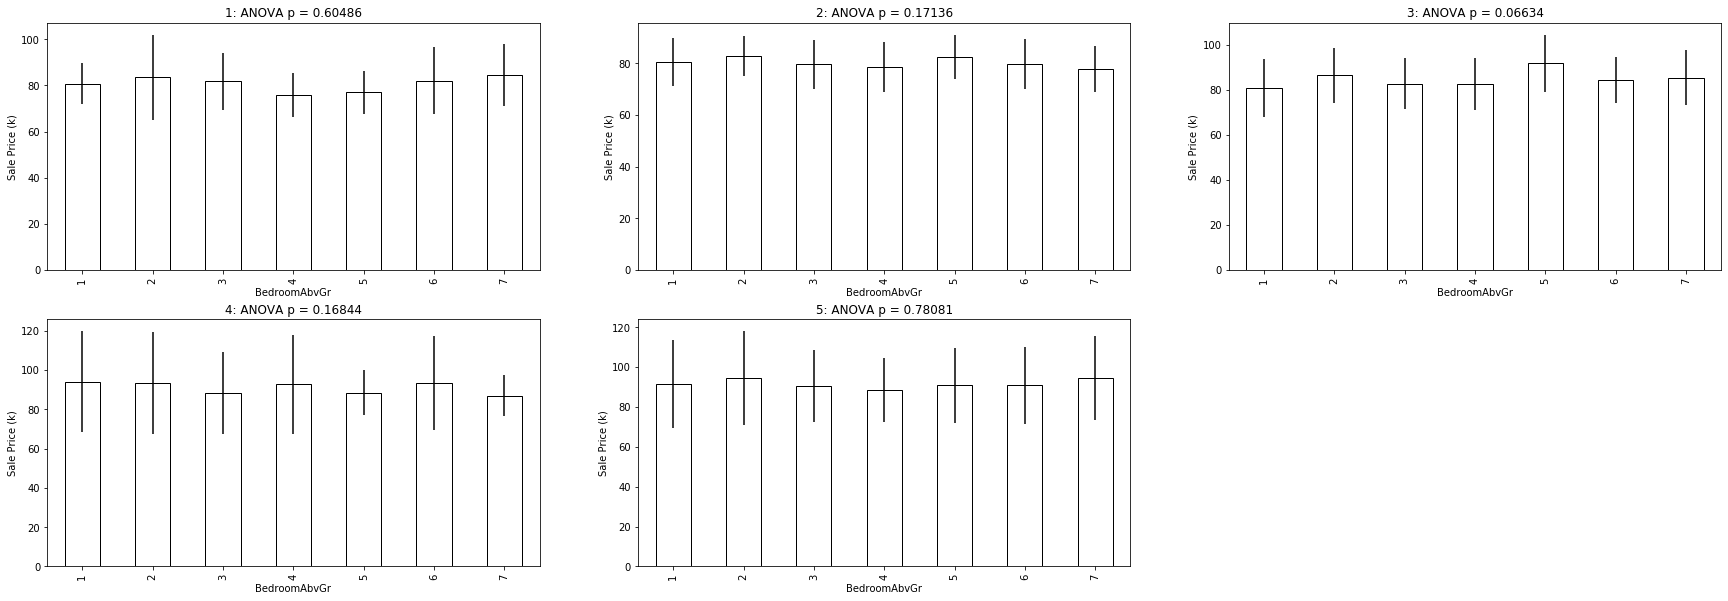

In [240]:
fig5 = plt.figure(figsize=(30,10))
for i in range(1,6):
    print(i)
    df_s = df1.sample(100*i,replace=True)
    df_new = simulate_bedroom_cols(df_s,cols[2:32])
    df_new2 = simulation_price(model,df_new)
    
    #Add ANOVA analysis
    new_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new).fit()
    aov = sm.stats.anova_lm(new_stats, typ=2)
    name = str(i)+': ANOVA p = '+str(round(aov['PR(>F)']['BedroomAbvGr'],5) )
    
    #plot mean
    ax = fig5.add_subplot(2,3,i)
    plot_mean_sd_BR_2(df_new2,name)


# The Conclusion:
## Even though we saw a negative correlation in the original data sets between bedroom number and Sale Price, after simulation experimenting, we found, this correlation is not a cause but a random association, and bedroom number is actually one of the least considered features to affect house price.

## This study is one example to show that we should be careful to avoid miss interpreting association with causation.